In [2]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingutils as ising

In [3]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')
model_dir = 'E:\\Ising_model_results_daai'
# model_dir = 'E:\\Ising_model_results_batch'

In [4]:
# param_string = 'pl_data_validation_nodes_360_rep_19_epochs_100000_lr_1e-05_threshold_0.1_beta_0.5_start_0_end_83'
# param_string = 'data_validation_nodes_360_rep_0_epochs_1000_p_0.20000000298023224_lr_0.001_threshold_0.1_start_0_end_83'
# param_string = 'window_length_test_nodes_360_epochs_10_max_window_1200_lr_0.001_threshold_0.100_subject_320826'
# param_string = 'window_length_test_nodes_21_epochs_1000_max_window_10_lr_0.001_threshold_0.100_subject_158035'
# param_string = 'window_length_test_nodes_21_epochs_1000_max_window_10_lr_0.001_threshold_0.100_subject_158035'
param_string = 'nodes_21_reps_1000_epochs_19200_window_96_lr_0.001_threshold_0.100_subject_128127'
h_file_name = os.path.join(model_dir, f'h_{param_string}.pt')
h_file_stat = os.stat(h_file_name)
print(f'h file {h_file_name} is {h_file_stat.st_size} bytes')
h = torch.load(h_file_name).squeeze()
print( 'h size', h.size() )
print( 'h dtype', h.dtype )
h_element_size = h.element_size()
h_nelement = h.nelement()
h_size = h_element_size * h_nelement
print( f'{h_nelement} elements x {h_element_size} bytes/element = {h_size} bytes' )
J_file_name = os.path.join(model_dir, f'J_{param_string}.pt')
J_file_stat = os.stat(J_file_name)
print(f'J file {J_file_name} is {J_file_stat.st_size} bytes')
J = torch.load( os.path.join(model_dir, f'J_{param_string}.pt') )
print( 'J size', J.size() )
print( 'J dtype', J.dtype )
J_element_size = J.element_size()
J_nelement = J.nelement()
J_size = J_element_size * J_nelement
print( f'{J_nelement} elements x {J_element_size} bytes/element = {J_size} bytes' )

h file E:\Ising_model_results_daai\h_nodes_21_reps_1000_epochs_19200_window_96_lr_0.001_threshold_0.100_subject_128127.pt is 85848 bytes
h size torch.Size([1000, 21])
h dtype torch.float32
21000 elements x 4 bytes/element = 84000 bytes
J file E:\Ising_model_results_daai\J_nodes_21_reps_1000_epochs_19200_window_96_lr_0.001_threshold_0.100_subject_128127.pt is 1765848 bytes
J size torch.Size([1000, 21, 21])
J dtype torch.float32
441000 elements x 4 bytes/element = 1764000 bytes


In [5]:
data_directory = 'E:\\HCP_data'
data_subset = 'validation'
if data_subset == 'validation':
    subject_ids = hcp.load_validation_subjects(directory_path=data_directory)
else:
    subject_ids = hcp.load_training_subjects(directory_path=data_directory)
data_ts = hcp.load_all_time_series_for_subjects(directory_path=data_directory, subject_ids=subject_ids, dtype=float_type, device=device)
# print( data_ts.size() )
data_ts = ising.standardize_and_binarize_ts_data(ts=data_ts, time_dim=-2).flatten(start_dim=1, end_dim=2)
num_subjects, num_time_points, num_nodes = data_ts.size()
print(f'num subjects {num_subjects}, num_time_points {num_time_points}, num_nodes {num_nodes}')

num subjects 84, num_time_points 4800, num_nodes 360


In [6]:
if num_subjects > h.size(dim=0):
    num_subjects = h.size(dim=0)
    data_ts = data_ts[:num_subjects,:,:]

In [7]:
batch_size, num_nodes = h.size()
num_time_points = 2400
sim_ts = torch.zeros( (batch_size, num_time_points, num_nodes), dtype=float_type, device=device )
_, _, s = ising.get_batched_ising_models(batch_size=num_subjects, num_nodes=num_nodes, dtype=float_type, device=device)
sim_ts, s = ising.run_batched_balanced_metropolis_sim(sim_ts=sim_ts, J=J, h=h, s=s, num_steps=num_time_points)
print( 'sim_ts size ', sim_ts.size() )

RuntimeError: The size of tensor a (1000) must match the size of tensor b (84) at non-singleton dimension 0

In [ ]:
sim_ts = torch.load( os.path.join('E:', 'Ising_model_results_batch', f'sim_ts_{param_string}.pt') )
print( 'sim_ts size ', sim_ts.size() )

In [ ]:
data_fc = hcp.get_fc_batch(data_ts)
sim_fc = hcp.get_fc_batch(sim_ts)
fc_rmse = hcp.get_triu_rmse_batch(data_fc, sim_fc)
fc_corr = hcp.get_triu_corr_batch(data_fc, sim_fc)

In [8]:
def print_stats(name:str, values:torch.Tensor):
    values_flat = values.flatten()
    values_is_nan = torch.isnan(values_flat)
    num_nan = torch.count_nonzero(values_is_nan)
    num_vals = torch.numel(values_flat)
    values_is_not_nan = torch.logical_not(values_is_nan)
    non_nan_values = values_flat[values_is_not_nan]
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(non_nan_values, quantile_cutoffs)
    min_val = torch.min(non_nan_values)
    max_val = torch.max(non_nan_values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}]. We have {num_nan} NaN values out of {num_vals} values.')

In [9]:
# error_file_param_string = 'window_length_test_nodes_360_epochs_2100_max_window_2400_lr_0.001_threshold_0.100'
# error_file_param_string = 'window_length_test_nodes_360_epochs_10000_max_window_2400_lr_0.001_threshold_0.100_length_4800'
# error_file_param_string = 'window_length_test_nodes_21_epochs_1000_max_window_10_lr_0.001_threshold_0.100_length_4800'
# error_file_param_string = 'window_length_test_nodes_21_epochs_1000_max_window_10_lr_0.001_threshold_0.100_length_4800_all'
# error_file_param_string = 'parallel_sim_nodes_21_epochs_999_sims_2400_window_50_lr_0.001_threshold_0.100_length_4800_516742_model_0_sims_1000'
# error_file_param_string = '_parallel_nodes_21_epochs_1000_reps_100_window_50_lr_0.001_threshold_0.100_beta_0.500_model_0_sims_1000_length_48000_subject_516742'
error_file_param_string = 'parallel_sim_nodes_360_epochs_9999_sims_2400_window_50_lr_0.001_threshold_0.100_model_0_sims_100_length_4800_subject_516742'
fc_rmse = torch.load( os.path.join(model_dir, f'fc_rmse_{error_file_param_string}.pt') )
print( 'fc_rmse size', fc_rmse.size() )
fc_corr = torch.load( os.path.join(model_dir, f'fc_corr_{error_file_param_string}.pt') )
print( 'fc_corr size', fc_corr.size() )

fc_rmse size torch.Size([1, 100])
fc_corr size torch.Size([1, 100])


In [10]:
print(  torch.count_nonzero( torch.isnan(fc_rmse) )  )
print(  torch.count_nonzero( torch.isnan(fc_corr) )  )

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


The distribution of FC RMSE values has median 0.402 with 95% CI [0.359, 0.465] and range [0.342, 0.512]. We have 0 NaN values out of 100 values.


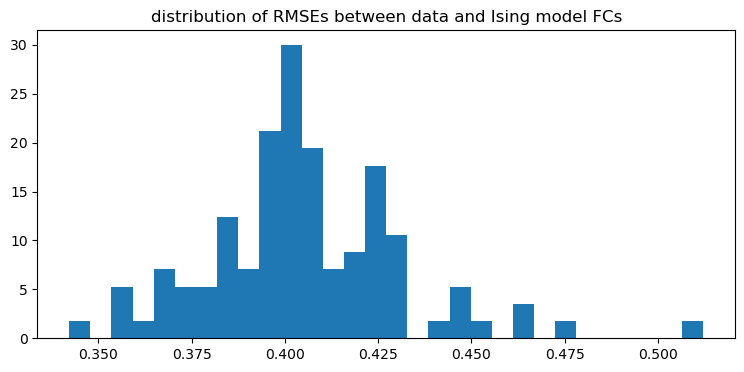

In [11]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
n_bins = 30
axs.hist( fc_rmse.flatten().detach().cpu().numpy(), n_bins, density=True, histtype='bar' )
axs.set_title('distribution of RMSEs between data and Ising model FCs')
print_stats( name='FC RMSE', values=fc_rmse.flatten() )

The distribution of FC correlation values has median 0.145 with 95% CI [0.055, 0.288] and range [0.0347, 0.305]. We have 0 NaN values out of 100 values.


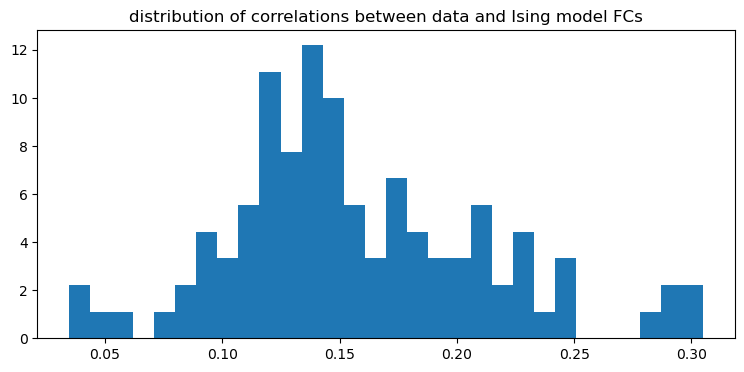

In [12]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
n_bins = 30
axs.hist( fc_corr.flatten().detach().cpu().numpy(), n_bins, density=True, histtype='bar' )
axs.set_title('distribution of correlations between data and Ising model FCs')
print_stats( name='FC correlation', values=fc_corr.flatten() )

ValueError: x and y must have same first dimension, but have shapes (2399,) and (100,)

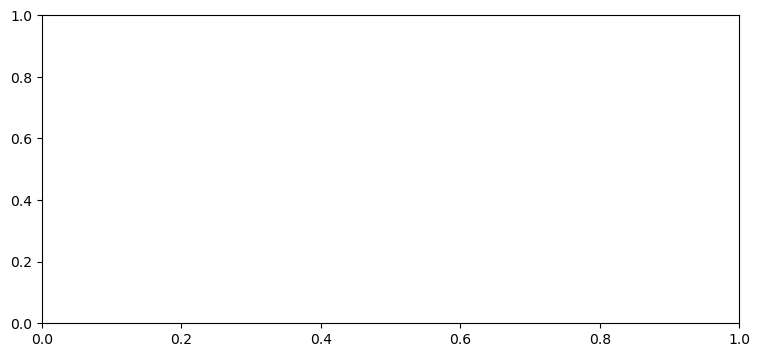

In [13]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
window_sizes = range(1,2400)
axs.plot( window_sizes, fc_rmse.flatten().detach().cpu().numpy() )
axs.set_xlabel('window size')
axs.set_ylabel('FC RMSE')
axs.set_title('FC RMSE vs window size for 360 node model trained for 10000 epochs')
print_stats( name='FC RMSE', values=fc_rmse.flatten() )

The distribution of FC correlation values has median 0.102 with 95% CI [0.0383, 0.311] and range [0.0056, 0.417]. We have 0 NaN values out of 2399 values.


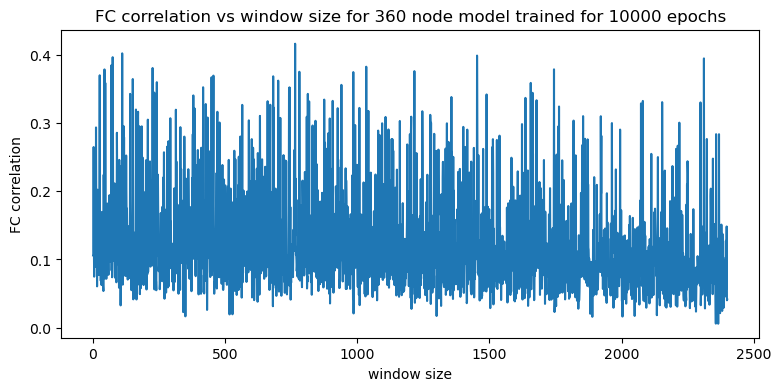

In [14]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
window_sizes = range(1,2400)
axs.plot( window_sizes, fc_corr.flatten().detach().cpu().numpy() )
axs.set_xlabel('window size')
axs.set_ylabel('FC correlation')
axs.set_title('FC correlation vs window size for 360 node model trained for 10000 epochs')
print_stats( name='FC correlation', values=fc_corr.flatten() )

In [15]:
def moving_average(values:torch.Tensor, window_length:int, dim:int=0):
    return torch.nn.functional.conv1d(  input=values.unsqueeze(dim=0), weight=torch.ones( (1,1,window_length), dtype=values.dtype, device=values.device )/window_length, bias=None, stride=1, padding=0, dilation=1, groups=1  ).squeeze()

In [16]:
filter_length = 240
fc_rmse_avg = moving_average(values=fc_rmse, window_length=filter_length)
print( fc_rmse_avg.size() )

torch.Size([2160])


The distribution of FC RMSE values has median 0.314 with 95% CI [0.309, 0.362] and range [0.308, 0.384]. We have 0 NaN values out of 2160 values.
Lowest FC RMSE occurs at window length 866.


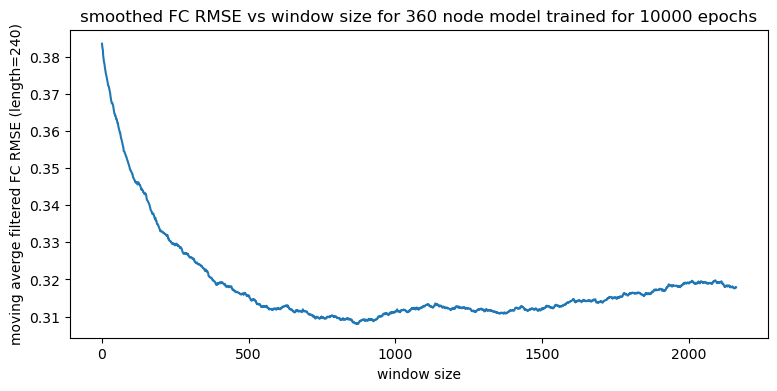

In [17]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
window_sizes = range( 1, fc_rmse_avg.size(dim=0)+1 )
axs.plot( window_sizes, fc_rmse_avg.flatten().detach().cpu().numpy() )
axs.set_xlabel('window size')
axs.set_ylabel(f'moving averge filtered FC RMSE (length={filter_length})')
axs.set_title('smoothed FC RMSE vs window size for 360 node model trained for 10000 epochs')
print_stats( name='FC RMSE', values=fc_rmse_avg.flatten() )
best_length_for_rmse = window_sizes[ torch.argmin(fc_rmse_avg) ]
print(f'Lowest FC RMSE occurs at window length {best_length_for_rmse}.')

In [19]:
filter_length = 240
fc_corr_avg = moving_average(values=fc_corr, window_length=filter_length)
print( fc_corr_avg.size() )

torch.Size([2160])


The distribution of FC correlation values has median 0.121 with 95% CI [0.0937, 0.146] and range [0.092, 0.149]. We have 0 NaN values out of 2160 values.
Lowest FC correlation occurs at window length 2160.


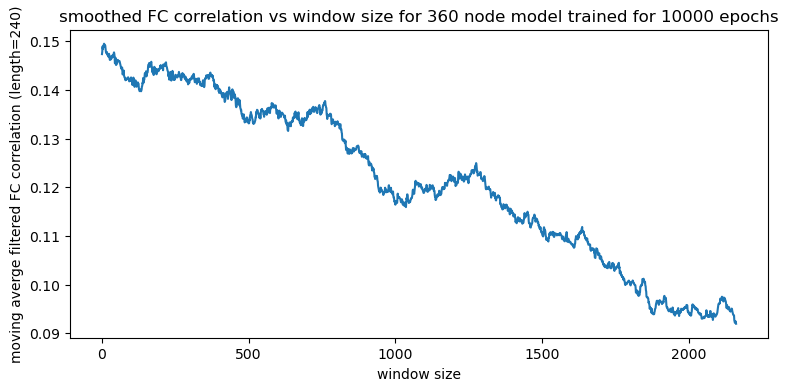

In [20]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 4) )
window_sizes = range( 1, fc_corr_avg.size(dim=0)+1 )
axs.plot( window_sizes, fc_corr_avg.flatten().detach().cpu().numpy() )
axs.set_xlabel('window size')
axs.set_ylabel(f'moving averge filtered FC correlation (length={filter_length})')
axs.set_title('smoothed FC correlation vs window size for 360 node model trained for 10000 epochs')
print_stats( name='FC correlation', values=fc_corr_avg.flatten() )
best_length_for_corr = window_sizes[ torch.argmin(fc_corr_avg) ]
print(f'Lowest FC correlation occurs at window length {best_length_for_corr}.')

In [56]:
# h_test = torch.load('E:\\Ising_model_results_daai\\h_parallel_sim_nodes_21_epochs_699_sims_2400_window_50_lr_0.001_threshold_0.100_subject_748662.pt')
h_test = torch.load('E:\\Ising_model_results_daai\\h__parallel_nodes_21_epochs_1000_reps_10_window_50_lr_0.001_threshold_0.100_beta_0.500_subject_103111.pt')
print( h_test.size() )

torch.Size([10, 21])


In [14]:
param_string = 'hyperparam_test_pl_nodes_21_epochs_100000_thresh_0.100_subject_125525'
hyperparameter_fc_rmse = torch.load(f'E:\\Ising_model_results_daai\\rmse_{param_string}.pt')
print( hyperparameter_fc_rmse.size() )
hyperparameter_fc_corr = torch.load(f'E:\\Ising_model_results_daai\\corr_{param_string}.pt')
print( hyperparameter_fc_corr.size() )

torch.Size([3, 4, 1000])
torch.Size([3, 4, 1000])


In [15]:
learning_rates = [0.1, 0.001, 0.00001]
batch_sizes = [4800, 1200, 600, 75]

In [16]:
print( hyperparameter_fc_rmse.mean(dim=-1) )
print( hyperparameter_fc_corr.mean(dim=-1) )

tensor([[0.1813, 0.1736, 0.1812, 0.1868],
        [0.1773, 0.1770, 0.1776, 0.1776],
        [0.2290, 0.1789, 0.1767, 0.1788]], device='cuda:0')
tensor([[0.7027, 0.6696, 0.6488, 0.6732],
        [0.7044, 0.6950, 0.7021, 0.7015],
        [0.6736, 0.7031, 0.7030, 0.7024]], device='cuda:0')


In [17]:
print( hyperparameter_fc_rmse.std(dim=-1) )
print( hyperparameter_fc_corr.std(dim=-1) )

tensor([[0.0556, 0.0523, 0.0563, 0.0567],
        [0.0556, 0.0535, 0.0550, 0.0558],
        [0.0710, 0.0562, 0.0553, 0.0556]], device='cuda:0')
tensor([[0.1115, 0.1254, 0.1352, 0.1202],
        [0.1198, 0.1150, 0.1152, 0.1182],
        [0.0956, 0.1109, 0.1167, 0.1139]], device='cuda:0')


In [70]:
print( hyperparameter_fc_rmse[0,0,0].item() )

0.10306799411773682
